<a href="https://colab.research.google.com/github/xaldoxxx/BlockDeNotas/blob/main/apuestas002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1], 'Resultado': self.calcular_resultado(), 'Puntos': self.calcular_puntos()}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    def calcular_resultado(self):
        if self.resultado[0] > self.resultado[1]:
            return 1  # Gana equipo local
        elif self.resultado[0] < self.resultado[1]:
            return -1  # Gana equipo visitante
        else:
            return 0  # Empate

    def calcular_puntos(self):
        resultado = self.calcular_resultado()
        if resultado == 1:
            return 3  # Equipo local gana
        elif resultado == 0:
            return 1  # Empate
        else:
            return 0  # Equipo visitante gana

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if len(valores) > 1 else 0
            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos

# Obtener la página web
url_base = "https://argentina.as.com/resultados/futbol/argentina/2023/jornada/regular_a_"
partidos = []

# Iterar sobre las jornadas desde regular_a_1 hasta regular_a_16
for i in range(1, 27):
    url = url_base + str(i) + "/"
    partidos.extend(Partido.crear_partidos(url))

# Guardar en archivo CSV y mostrar información de los partidos
filename = 'partidos.csv'
for partido in partidos:
    partido.guardar_csv(filename)
    #partido.mostrar_info

# Separar partidos por equipo en dataframes individuales
equipo_partidos = {}
for partido in partidos:
    local = partido.local
    visitante = partido.visitante

    # Equipo local
    if local not in equipo_partidos:
        equipo_partidos[local] = []
    equipo_partidos[local].append(partido)

    # Equipo visitante
    if visitante not in equipo_partidos:
        equipo_partidos[visitante] = []
    equipo_partidos[visitante].append(partido)

# Crear un dataframe y guardar en un archivo CSV por cada equipo
for equipo, partidos_equipo in equipo_partidos.items():
    equipo_filename = equipo.lower().replace(' ', '_') + '.csv'
    equipo_df = pd.DataFrame({
        'ID': [partido.id for partido in partidos_equipo],
        'Fecha': [partido.fecha for partido in partidos_equipo],
        'EquipoLocal': [partido.local for partido in partidos_equipo],
        'EquipoVisitante': [partido.visitante for partido in partidos_equipo],
        'GLocal': [partido.resultado[0] for partido in partidos_equipo],
        'GVisitante': [partido.resultado[1] for partido in partidos_equipo],
        'GolesAFavor': [partido.resultado[0] if partido.local == equipo else partido.resultado[1] for partido in partidos_equipo],
        'GolesEnContra': [partido.resultado[1] if partido.local == equipo else partido.resultado[0] for partido in partidos_equipo],
        'Resultado': [partido.calcular_resultado() for partido in partidos_equipo],
        'Puntos': [partido.calcular_puntos() for partido in partidos_equipo]
    })
    equipo_df.to_csv(equipo_filename, index=False)


In [18]:
import pandas as pd

class PrediccionPartido:
    def __init__(self, equipo_local_filename, equipo_visitante_filename):
        self.equipo_local_df = pd.read_csv(equipo_local_filename)
        self.equipo_visitante_df = pd.read_csv(equipo_visitante_filename)

    def predecir_resultado(self):
        resultado_equipo1 = self.equipo_local_df.loc[0, 'Resultado']
        resultado_equipo2 = self.equipo_visitante_df.loc[0, 'Resultado']

        if resultado_equipo1 > resultado_equipo2:
            return "Gana el equipo Local"
        elif resultado_equipo1 < resultado_equipo2:
            return "Gana el equipo Visitante"
        else:
            return "Empate"


In [19]:
# Obtener los nombres de archivo de los equipos del usuario
equipo_local_filename = input("Ingrese el nombre del archivo del equipo local: ")
equipo_visitante_filename = input("Ingrese el nombre del archivo del equipo visitante: ")

# Crear una instancia de PrediccionPartido
prediccion = PrediccionPartido(equipo_local_filename, equipo_visitante_filename)

# Obtener la predicción del resultado
resultado_prediccion = prediccion.predecir_resultado()

# Imprimir el resultado
print(f"El resultado predicho es: {resultado_prediccion}")


Ingrese el nombre del archivo del equipo local: /content/barracas_central.csv
Ingrese el nombre del archivo del equipo visitante: /content/rosario_central.csv
El resultado predicho es: Gana el equipo Visitante


In [20]:
import pandas as pd

class Equipo:
    def __init__(self, nombre, dataframe):
        self.nombre = nombre
        self.dataframe = dataframe

    def obtener_puntos(self):
        return self.dataframe['Puntos'].sum()

    def predecir_resultado(self, otro_equipo):
        puntos_equipo1 = self.obtener_puntos()
        puntos_equipo2 = otro_equipo.obtener_puntos()

        if puntos_equipo1 > puntos_equipo2:
            resultado = f"Gana {self.nombre}"
        elif puntos_equipo1 < puntos_equipo2:
            resultado = f"Gana {otro_equipo.nombre}"
        else:
            resultado = "Empate"

        return resultado

# Obtener los nombres de archivo de los equipos del usuario
equipo_local_filename = input("Ingrese el nombre del archivo del equipo local: ")
equipo_visitante_filename = input("Ingrese el nombre del archivo del equipo visitante: ")

# Carga de los dataframes de los equipos
equipo_local_df = pd.read_csv(equipo_local_filename)
equipo_visitante_df = pd.read_csv(equipo_visitante_filename)

# Creación de objetos Equipo
equipo1 = Equipo('Equipo Local', equipo_local_df)
equipo2 = Equipo('Equipo Visitante', equipo_visitante_df)

# Predicción del resultado
resultado_prediccion = equipo1.predecir_resultado(equipo2)

# Imprimir el resultado
print(resultado_prediccion)



Ingrese el nombre del archivo del equipo local: /content/barracas_central.csv
Ingrese el nombre del archivo del equipo visitante: /content/rosario_central.csv
Gana Equipo Visitante


In [21]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import statistics

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1], 'Resultado': self.calcular_resultado(), 'Puntos': self.calcular_puntos()}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    def calcular_resultado(self):
        if self.resultado[0] > self.resultado[1]:
            return 'Equipo local gana'
        elif self.resultado[0] < self.resultado[1]:
            return 'Equipo visitante gana'
        else:
            return 'Empate'

    def calcular_puntos(self):
        resultado = self.calcular_resultado()
        if resultado == 'Equipo local gana':
            return 3  # Equipo local gana
        elif resultado == 'Empate':
            return 1  # Empate
        else:
            return 0  # Equipo visitante gana

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if len(valores) > 1 else 0
            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos

class Equipo:
    def __init__(self, nombre, dataframe):
        self.nombre = nombre
        self.dataframe = dataframe

    def obtener_puntos(self):
        return self.dataframe['Puntos'].sum()

    def predecir_resultado(self, otro_equipo):
        media_equipo1 = statistics.mean(self.dataframe['Resultado'])
        media_equipo2 = statistics.mean(otro_equipo.dataframe['Resultado'])

        if media_equipo1 > media_equipo2:
            resultado = f"Gana {self.nombre}"
        elif media_equipo1 < media_equipo2:
            resultado = f"Gana {otro_equipo.nombre}"
        else:
            resultado = "Empate"

        return resultado

# Obtener los nombres de archivo de los equipos del usuario
equipo1_filename = input("Ingrese el nombre del archivo del equipo local: ")
equipo2_filename = input("Ingrese el nombre del archivo del equipo visitante: ")

# Cargar los dataframes de los equipos
equipo1_df = pd.read_csv(equipo1_filename)
equipo2_df = pd.read_csv(equipo2_filename)

# Crear objetos Equipo
equipo1 = Equipo('Equipo Local', equipo1_df)
equipo2 = Equipo('Equipo Visitante', equipo2_df)

# Predecir el resultado
resultado_prediccion = equipo1.predecir_resultado(equipo2)

# Imprimir el resultado
print(resultado_prediccion)


Ingrese el nombre del archivo del equipo local: /content/barracas_central.csv
Ingrese el nombre del archivo del equipo visitante: /content/rosario_central.csv
Gana Equipo Visitante


In [23]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import statistics

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1], 'Resultado': self.calcular_resultado(), 'Puntos': self.calcular_puntos()}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    def calcular_resultado(self):
        if self.resultado[0] > self.resultado[1]:
            return 'Equipo local gana'
        elif self.resultado[0] < self.resultado[1]:
            return 'Equipo visitante gana'
        else:
            return 'Empate'

    def calcular_puntos(self):
        resultado = self.calcular_resultado()
        if resultado == 'Equipo local gana':
            return 3  # Equipo local gana
        elif resultado == 'Empate':
            return 1  # Empate
        else:
            return 0  # Equipo visitante gana

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if len(valores) > 1 else 0
            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos

class Equipo:
    def __init__(self, nombre, dataframe):
        self.nombre = nombre
        self.dataframe = dataframe

    def obtener_puntos(self):
        return self.dataframe['Puntos'].sum()

    def predecir_resultado(self, otro_equipo):
        media_equipo1 = statistics.mean(self.dataframe['Resultado'])
        media_equipo2 = statistics.mean(otro_equipo.dataframe['Resultado'])

        if media_equipo1 > media_equipo2:
            resultado = f"Gana {self.nombre}"
        elif media_equipo1 < media_equipo2:
            resultado = f"Gana {otro_equipo.nombre}"
        else:
            resultado = "Empate"

        return resultado

# Solicitar nombres de archivo de los equipos locales y visitantes
equipo1_filename = input("Ingrese el nombre del archivo del equipo local: ")
equipo2_filename = input("Ingrese el nombre del archivo del equipo visitante: ")

# Cargar los dataframes de los equipos
equipo1_df = pd.read_csv(equipo1_filename)
equipo2_df = pd.read_csv(equipo2_filename)

# Crear objetos Equipo
equipo1 = Equipo('Equipo Local', equipo1_df)
equipo2 = Equipo('Equipo Visitante', equipo2_df)

# Predecir el resultado
resultado_prediccion = equipo1.predecir_resultado(equipo2)

# Imprimir el resultado
print(resultado_prediccion)


Ingrese el nombre del archivo del equipo local: /content/barracas_central.csv
Ingrese el nombre del archivo del equipo visitante: /content/rosario_central.csv
Gana Equipo Visitante


Ingrese el nombre de archivo del equipo local: /content/barracas_central.csv
Ingrese el nombre de archivo del equipo visitante: /content/rosario_central.csv
Gana Equipo Visitante
Percentiles Equipo 1: [-1.0, -0.6, 0.0, 0.0, 0.0, 0.0, 0.9, 1.0, 1.0]
Percentiles Equipo 2: [-0.3, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]


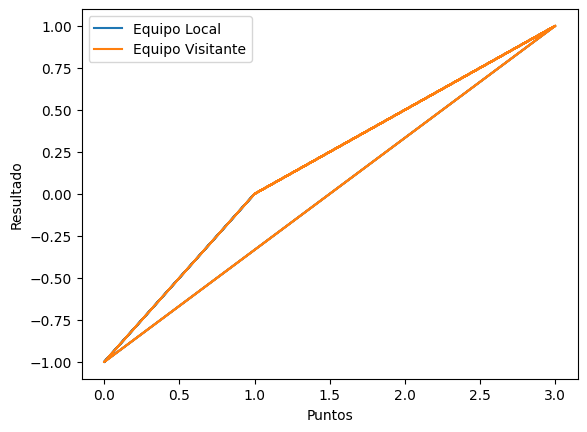

In [25]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import statistics
import matplotlib.pyplot as plt

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1], 'Resultado': self.calcular_resultado(), 'Puntos': self.calcular_puntos()}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    def calcular_resultado(self):
        if self.resultado[0] > self.resultado[1]:
            return 'Equipo local gana'
        elif self.resultado[0] < self.resultado[1]:
            return 'Equipo visitante gana'
        else:
            return 'Empate'

    def calcular_puntos(self):
        resultado = self.calcular_resultado()
        if resultado == 'Equipo local gana':
            return 3  # Equipo local gana
        elif resultado == 'Empate':
            return 1  # Empate
        else:
            return 0  # Equipo visitante gana

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if valores else 0

            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos


class Equipo:
    def __init__(self, nombre, dataframe):
        self.nombre = nombre
        self.dataframe = dataframe

    def obtener_puntos(self):
        return self.dataframe['Puntos'].sum()

    def predecir_resultado(self, otro_equipo):
        puntos_equipo1 = self.obtener_puntos()
        puntos_equipo2 = otro_equipo.obtener_puntos()

        media_equipo1 = statistics.mean(self.dataframe['Resultado'])
        media_equipo2 = statistics.mean(otro_equipo.dataframe['Resultado'])

        percentiles_equipo1 = statistics.quantiles(self.dataframe['Resultado'], n=10)
        percentiles_equipo2 = statistics.quantiles(otro_equipo.dataframe['Resultado'], n=10)

        if media_equipo1 > media_equipo2:
            resultado = f"Gana {self.nombre}"
        elif media_equipo1 < media_equipo2:
            resultado = f"Gana {otro_equipo.nombre}"
        else:
            resultado = "Empate"

        return resultado, percentiles_equipo1, percentiles_equipo2


# Solicitar nombres de archivo de los equipos al usuario
nombre_archivo_local = input("Ingrese el nombre de archivo del equipo local: ")
nombre_archivo_visitante = input("Ingrese el nombre de archivo del equipo visitante: ")

# Cargar los dataframes de los equipos
equipo1_df = pd.read_csv(nombre_archivo_local)
equipo2_df = pd.read_csv(nombre_archivo_visitante)

# Crear objetos Equipo
equipo1 = Equipo('Equipo Local', equipo1_df)
equipo2 = Equipo('Equipo Visitante', equipo2_df)

# Predecir el resultado
resultado_prediccion, percentiles_equipo1, percentiles_equipo2 = equipo1.predecir_resultado(equipo2)

# Imprimir el resultado
print(resultado_prediccion)

# Imprimir los percentiles
print(f'Percentiles Equipo 1: {percentiles_equipo1}')
print(f'Percentiles Equipo 2: {percentiles_equipo2}')

# Graficar los puntos y resultados
plt.plot(equipo1.dataframe['Puntos'], equipo1.dataframe['Resultado'], label=equipo1.nombre)
plt.plot(equipo2.dataframe['Puntos'], equipo2.dataframe['Resultado'], label=equipo2.nombre)
plt.xlabel('Puntos')
plt.ylabel('Resultado')
plt.legend()
plt.show()


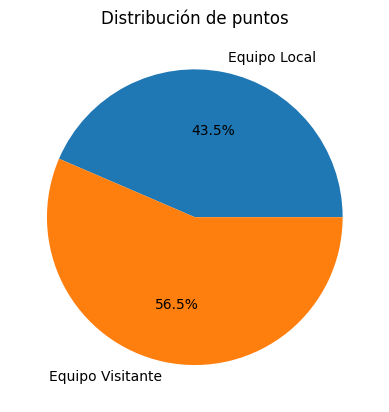

In [26]:
# Calcular los puntos totales de cada equipo
puntos_equipo1 = equipo1.obtener_puntos()
puntos_equipo2 = equipo2.obtener_puntos()

# Crear una lista con los puntos totales de ambos equipos
puntos_totales = [puntos_equipo1, puntos_equipo2]

# Etiquetas para los equipos
etiquetas = [equipo1.nombre, equipo2.nombre]

# Crear el gráfico de torta
plt.pie(puntos_totales, labels=etiquetas, autopct='%0.01f%%')
plt.title('Distribución de puntos')
plt.show()


In [27]:
import pandas as pd
import numpy as np

class Partido:
    def __init__(self, local, visitante, resultado):
        self.local = local
        self.visitante = visitante
        self.resultado = resultado

    def calcular_puntos(self):
        if self.resultado[0] > self.resultado[1]:
            return 3  # Equipo local gana
        elif self.resultado[0] < self.resultado[1]:
            return 0  # Equipo visitante gana
        else:
            return 1  # Empate


class Equipo:
    def __init__(self, nombre, partidos):
        self.nombre = nombre
        self.partidos = partidos

    def obtener_puntos(self):
        return sum(partido.calcular_puntos() for partido in self.partidos)

    def predecir_resultado(self, otro_equipo):
        puntos_equipo1 = self.obtener_puntos()
        puntos_equipo2 = otro_equipo.obtener_puntos()

        resultado_equipo1 = np.mean([partido.resultado[0] for partido in self.partidos])
        resultado_equipo2 = np.mean([partido.resultado[1] for partido in otro_equipo.partidos])

        if resultado_equipo1 > resultado_equipo2:
            return f"Gana {self.nombre}"
        elif resultado_equipo1 < resultado_equipo2:
            return f"Gana {otro_equipo.nombre}"
        else:
            return "Empate"

    def calcular_rsi(self):
        resultados = [partido.resultado[0] for partido in self.partidos]
        ganancias = [resultados[i+1] - resultados[i] for i in range(len(resultados)-1) if resultados[i+1] > resultados[i]]
        perdidas = [-resultados[i+1] + resultados[i] for i in range(len(resultados)-1) if resultados[i+1] < resultados[i]]
        avg_gain = np.mean(ganancias)
        avg_loss = np.mean(perdidas)
        rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
        return rsi


class PrediccionPartido:
    def __init__(self, equipo_local_filename, equipo_visitante_filename):
        equipo_local_df = pd.read_csv(equipo_local_filename)
        equipo_visitante_df = pd.read_csv(equipo_visitante_filename)
        self.equipo_local = Equipo('Equipo Local', self.crear_partidos(equipo_local_df))
        self.equipo_visitante = Equipo('Equipo Visitante', self.crear_partidos(equipo_visitante_df))

    @staticmethod
    def crear_partidos(df):
        partidos = []
        for _, row in df.iterrows():
            local = row['EquipoLocal']
            visitante = row['EquipoVisitante']
            resultado = (row['GLocal'], row['GVisitante'])
            partido = Partido(local, visitante, resultado)
            partidos.append(partido)
        return partidos

    def predecir_resultado(self):
        return self.equipo_local.predecir_resultado(self.equipo_visitante)


prediccion = PrediccionPartido('/content/barracas_central.csv', '/content/rosario_central.csv')
resultado_prediccion = prediccion.predecir_resultado()
rsi_equipo_local = prediccion.equipo_local.calcular_rsi()
rsi_equipo_visitante = prediccion.equipo_visitante.calcular_rsi()

print(resultado_prediccion)
print(f'RSI Equipo Local: {rsi_equipo_local}')
print(f'RSI Equipo Visitante: {rsi_equipo_visitante}')


Gana Equipo Visitante
RSI Equipo Local: 57.14285714285714
RSI Equipo Visitante: 34.46808510638297
